In [140]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import sentencepiece as spm
import re
import random
from sklearn.model_selection import train_test_split

Загрузка и подготовка текста

In [141]:
with open("Dostoyevski_Idiot.txt", "r", encoding="utf-8") as f:
    text = f.read()

In [142]:
text = text.replace('#', ' ').replace('\u00A0', ' ')
sentences = re.split(r'(?<=[.!?…])\s+', text)
sentences = [s.strip() for s in sentences if s.strip()]
sentences = sentences[:2000]

In [143]:
with open("idiot_mini.txt", "w", encoding="utf-8") as f:
    for s in sentences:
        f.write(s + "\n")

In [144]:
spm.SentencePieceTrainer.train(input="idiot_mini.txt", model_prefix="idiot_mini", vocab_size=600, model_type="bpe")
sp = spm.SentencePieceProcessor()
sp.load("idiot_mini.model")

True

In [145]:
vocab = [sp.IdToPiece(i) for i in range(sp.GetPieceSize())]
token_to_id = {piece: i for i, piece in enumerate(vocab)}
EOS_ID = len(token_to_id)
PAD_ID = len(token_to_id) + 1
token_to_id['[EOS]'] = EOS_ID
token_to_id['[PAD]'] = PAD_ID
vocab_size = len(token_to_id)

In [146]:
ids_sentences = []
for s in sentences:
    pieces = sp.EncodeAsPieces(s)
    ids = [token_to_id[p] for p in pieces if p in token_to_id]
    ids.append(EOS_ID)
    ids_sentences.append(ids)

Тренировочный набор (prefix → next token)

In [147]:
context_size = 32

In [148]:
class PrefixDataset(Dataset):
    def __init__(self, sequences, ctx_size, pad_id):
        self.data = []
        for tokens in sequences:
            for i in range(1, len(tokens)):
                prefix = tokens[max(0, i-ctx_size):i]
                if len(prefix) < ctx_size:
                    prefix = [pad_id] * (ctx_size - len(prefix)) + prefix
                self.data.append((prefix, tokens[i]))
    def __len__(self): return len(self.data)
    def __getitem__(self, idx): x, y = self.data[idx]; return torch.tensor(x), torch.tensor(y)

In [149]:
dataset = PrefixDataset(ids_sentences, context_size, PAD_ID)
train_data, test_data = train_test_split(dataset.data, test_size=0.2, random_state=52)

In [150]:
class SplitDataset(Dataset):
    def __init__(self, data): self.data = data
    def __len__(self): return len(self.data)
    def __getitem__(self, idx): x, y = self.data[idx]; return torch.tensor(x), torch.tensor(y)

In [151]:
train_loader = DataLoader(SplitDataset(train_data), batch_size=32, shuffle=True)
test_loader = DataLoader(SplitDataset(test_data), batch_size=32)

Архитектура LSTM

In [152]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=256, hidden_dim=512, num_layers=2, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None, return_all_logits=False):
        x = self.embedding(x)
        out, hidden = self.lstm(x, hidden)
        logits = self.fc(out)

        if return_all_logits:
            return logits, hidden
        else:
            return logits[:, -1], hidden

In [153]:
model = LSTMModel(vocab_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()

Обучение LSTM (1 эпоха)

In [154]:
num_epochs = 20
train_losses = []
test_losses = []

In [155]:
from tqdm import tqdm

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")

    for x, y in train_bar:
        optimizer.zero_grad()
        logits, _ = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        train_bar.set_postfix(loss=loss.item())

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for x, y in test_loader:
            logits, _ = model(x)
            loss = criterion(logits, y)
            total_test_loss += loss.item()
    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

Epoch 20: 100%|██████████| 1860/1860 [07:31<00:00,  4.12it/s, loss=3.02]


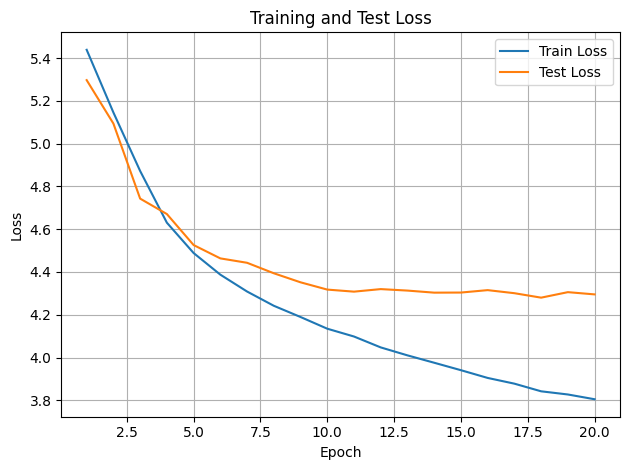

In [156]:
from matplotlib import pyplot as plt

plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Генерация текста (Greedy и Sampling)

In [157]:
def generate(model, prefix_ids, mode='greedy', max_len=20):
    model.eval()
    generated = prefix_ids[:]
    with torch.no_grad():
        for _ in range(max_len):
            context = generated[-context_size:]
            if len(context) < context_size:
                context = [PAD_ID] * (context_size - len(context)) + context
            inp = torch.tensor(context).unsqueeze(0)
            logits = model(inp)[0]
            probs = F.softmax(logits, dim=0)
            next_token = (
                torch.argmax(probs).item()
                if mode == 'greedy'
                else torch.multinomial(probs, 1).item()
            )
            generated.append(next_token)
            if next_token == EOS_ID: break
    return generated

In [158]:
def decode(ids):
    ids = [i for i in ids if i < len(vocab)]
    return sp.DecodePieces([vocab[i] for i in ids])

In [159]:
start_text = "Он был человек"
prefix = [token_to_id[p] for p in sp.EncodeAsPieces(start_text) if p in token_to_id]

In [160]:
greedy_out = generate(model, prefix, mode='greedy')
sample_out = generate(model, prefix, mode='sample')

In [161]:
print("LSTM Greedy :", decode(greedy_out))
print("LSTM Sample :", decode(sample_out))

LSTM Greedy : Он был человек ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇ 
LSTM Sample : Он был человеккомзареальиласьср Мариц жи тоси вся своднодраного ва ещеться


Генерация из разных начал

In [162]:
for line in ["Я тебя", "Вы мне", "Как хорошо"]:
    prefix = [token_to_id[p] for p in sp.EncodeAsPieces(line) if p in token_to_id]
    g = decode(generate(model, prefix, mode='greedy'))
    s = decode(generate(model, prefix, mode='sample'))
    print(f"\nНачало: {line}\n  [Greedy] {g}\n  [Sample] {s}")


Начало: Я тебя
  [Greedy] Я тебя ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇ 
  [Sample] Я тебяный На гоей маллсяютлаж ты ст нас гланимжд были импбяенерал

Начало: Вы мне
  [Greedy] Вы мне ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇ 
  [Sample] Вы мне се остайтеки у мал Тч знаю меняель гла Фалсяльб наст этовет

Начало: Как хорошо
  [Greedy] Как хорошо ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇ 
  [Sample] Как хорошоут тамся ми дру заЧэ тоутилиппеказвно негором часПва


Марковская цепь

In [163]:
transitions = {}
for seq in ids_sentences:
    for i in range(len(seq) - 1):
        a, b = seq[i], seq[i+1]
        if a not in transitions: transitions[a] = {}
        transitions[a][b] = transitions[a].get(b, 0) + 1

In [164]:
def markov_generate(start_ids, greedy=True, max_len=20):
    out = start_ids[:]
    for _ in range(max_len):
        last = out[-1]
        if last not in transitions: break
        options = transitions[last]
        if greedy:
            next_tok = max(options.items(), key=lambda x: x[1])[0]
        else:
            tokens, weights = zip(*options.items())
            next_tok = random.choices(tokens, weights=weights)[0]
        out.append(next_tok)
        if next_tok == EOS_ID: break
    return out

Примеры генерации по Марковской цепи

In [165]:
for line in ["Я тебя", "Вы мне", "Как хорошо"]:
    prefix = [token_to_id[p] for p in sp.EncodeAsPieces(line) if p in token_to_id]
    g = decode(markov_generate(prefix, greedy=True))
    s = decode(markov_generate(prefix, greedy=False))
    print(f"\n[Марков] {line}\n  [Greedy] {g}\n  [Sample] {s}")


[Марков] Я тебя
  [Greedy] Я тебят, что я, что я, что я, что я, что я, что я,
  [Sample] Я тебя стороны или не встеливай кажденемлюсь денькогда

[Марков] Вы мне
  [Greedy] Вы мне, что я, что я, что я, что я, что я, что я, что
  [Sample] Вы мне вдруг усывал Ровствензническорывать, а еще самы

[Марков] Как хорошо
  [Greedy] Как хорошордалиордалиордалиордалиордалиордалиордали
  [Sample] Как хорошо, надозведственком, какиали войдца, еще мал
